In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from sklearn import preprocessing
import lightgbm as lgb
from bayes_opt import BayesianOptimization

os.chdir('..')

all_df = pd.read_pickle('data/all_df.pkl')
all_df.head()

,channelGrouping,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,geoNetwork.country,...,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime,is_train
0,4,2016-09-02,35,0,False,20,1131660440785968503,378,3,210,...,4,1,11,5,3196,208,1472830385,1.0,1.472830e+09,1
1,4,2016-09-02,43,0,False,7,377306020877927890,955,5,12,...,4,1,11,5,3196,208,1472880147,1.0,1.472880e+09,1
2,4,2016-09-02,35,0,False,20,3895546263509774583,475,4,185,...,4,1,11,5,3196,208,1472865386,1.0,1.472865e+09,1
3,4,2016-09-02,79,0,False,6,4763447161404445595,955,3,94,...,4,1,1607,5,3196,208,1472881213,1.0,1.472881e+09,1
4,4,2016-09-02,35,1,True,1,27294437909732085,955,4,217,...,4,0,11,5,3196,208,1472822600,2.0,1.472823e+09,1


In [3]:
# Categorical features
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

# Numerical features
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    


In [25]:
train_df = all_df[all_df['is_train'] == 1]
test_df = all_df[all_df['is_train'] == 0]

train_y = np.log1p(train_df["totals.transactionRevenue"].values)
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

# Split the train dataset into development and valid based on time 
training_df = train_df[train_df['date'] <= datetime(2017,5,31)]
val_df = train_df[train_df['date'] > datetime(2017,5,31)]
training_y = np.log1p(training_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

training_X = training_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

In [31]:
# Bayesian optimization
def lgb_evaluate(min_child_samples,
                 num_leaves):
    params = {
                "objective" : "regression",
                "metric" : "rmse", 
                "learning_rate" : 0.01,
                "verbosity" : -1
                }
    params['num_leaves'] = int(num_leaves)
    params['min_child_samples'] = int(min_child_samples)


    lgtrain = lgb.Dataset(training_X, label=training_y, categorical_feature = cat_cols)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], valid_names = ['train', 'valid'],
                      early_stopping_rounds=100, verbose_eval=100)

    return -model.best_score['valid']['rmse']

lgbBO = BayesianOptimization(lgb_evaluate, {'num_leaves': (60, 120),
                                        'min_child_samples': (1, 50)}, random_state=0)
lgbBO.maximize(init_points=5, n_iter=25)

Initialization
------------------------------------------------------------------
 Step |   Time |      Value |   min_child_samples |   num_leaves | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['channelGrouping', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 't

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.65521	valid's rmse: 1.77379
[200]	train's rmse: 1.56953	valid's rmse: 1.70531
[300]	train's rmse: 1.52935	valid's rmse: 1.69233
[400]	train's rmse: 1.50127	valid's rmse: 1.68982
[500]	train's rmse: 1.47978	valid's rmse: 1.68988
Early stopping, best iteration is:
[452]	train's rmse: 1.48936	valid's rmse: 1.68963
    1 | 00m11s |   -1.68963 |             32.6488 |      92.9288 | 
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.65089	valid's rmse: 1.77163
[200]	train's rmse: 1.5628	valid's rmse: 1.70398
[300]	train's rmse: 1.51996	valid's rmse: 1.69229
[400]	train's rmse: 1.48987	valid's rmse: 1.6911
[500]	train's rmse: 1.4672	valid's rmse: 1.69136
Early stopping, best iteration is:
[439]	train's rmse: 1.48029	valid's rmse: 1.6908
    2 | 00m11s |   -1.69080 |             22.4418 |     102.9114 | 
Training until validation scores don't improve for 100 rounds.
[100]	tra

C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.59275969e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.35948524e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
------------------------------------------------------------------
 Step |   Time |      Value |   min_child_samples |   num_leaves | 
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66978	valid's rmse: 1.77969
[200]	train's rmse: 1.59065	valid's rmse: 1.70805
[300]	train's rmse: 1.555	valid's rmse: 1.69216
[400]	train's rmse: 1.53131	valid's rmse: 1.68818
[500]	train's rmse: 1.51385	valid's rmse: 1.68744
[600]	train's rmse: 1.50204	valid's rmse: 1.68775
Early stopping, best iteration is:
[546]	train's rmse: 1.50762	valid's rmse: 1.68722
    6 | 00m15s |   -1.68722 |              1.0865 |      60.0055 | 
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.64596	valid's rmse: 1.77092
[200]	train's rmse: 1.55579	valid's rmse: 1.70547
[300]	train's rmse: 1.51313	valid's rmse: 1.69453
[400]	train's rmse: 1.48244	valid's rmse: 1.69255
Early stopping, best iteration is:
[396]	train's rmse: 1.48357	val

C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00055955]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66591	valid's rmse: 1.77692
[200]	train's rmse: 1.58484	valid's rmse: 1.70689
[300]	train's rmse: 1.54786	valid's rmse: 1.69189
[400]	train's rmse: 1.52252	valid's rmse: 1.68801
[500]	train's rmse: 1.50378	valid's rmse: 1.68729
Early stopping, best iteration is:
[491]	train's rmse: 1.5052	valid's rmse: 1.68721
   11 | 00m15s |   -1.68721 |              4.5380 |      67.6692 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.46986848e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00141434]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.64378	valid's rmse: 1.76753
[200]	train's rmse: 1.55018	valid's rmse: 1.70458
[300]	train's rmse: 1.5025	valid's rmse: 1.69405
[400]	train's rmse: 1.46779	valid's rmse: 1.69275
[500]	train's rmse: 1.4412	valid's rmse: 1.69307
Early stopping, best iteration is:
[457]	train's rmse: 1.45155	valid's rmse: 1.69259
   12 | 00m15s |   -1.69259 |              1.1025 |     119.8613 | 
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.6702	valid's rmse: 1.78037
[200]	train's rmse: 1.59174	valid's rmse: 1.70947
[300]	train's rmse: 1.55686	valid's rmse: 1.69305
[400]	train's rmse: 1.53438	valid's rmse: 1.68932
[500]	train's rmse: 1.51782	valid's rmse: 1.6887
Early stopping, best iteration is:
[485]	train's rmse: 1.52005	valid's rmse: 1.68866
   13 | 00m15s |   -1.68866 |             49.8010 |      60.0638 | 
Training until validation scores don't improve for 100 rounds.
[100]	tra

C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.27918736e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66585	valid's rmse: 1.77737
[200]	train's rmse: 1.58545	valid's rmse: 1.70729
[300]	train's rmse: 1.54895	valid's rmse: 1.69265
[400]	train's rmse: 1.52472	valid's rmse: 1.68915
[500]	train's rmse: 1.50671	valid's rmse: 1.6884
Early stopping, best iteration is:
[488]	train's rmse: 1.50858	valid's rmse: 1.68835
   15 | 00m16s |   -1.68835 |             33.6658 |      68.6983 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00153391]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66385	valid's rmse: 1.77601
[200]	train's rmse: 1.58216	valid's rmse: 1.70663
[300]	train's rmse: 1.54436	valid's rmse: 1.69249
[400]	train's rmse: 1.51879	valid's rmse: 1.68918
[500]	train's rmse: 1.49935	valid's rmse: 1.68886
Early stopping, best iteration is:
[450]	train's rmse: 1.50864	valid's rmse: 1.6885
   16 | 00m15s |   -1.68850 |             16.8308 |      72.0043 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00127691]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00090889]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.67	valid's rmse: 1.78
[200]	train's rmse: 1.59135	valid's rmse: 1.70883
[300]	train's rmse: 1.55636	valid's rmse: 1.69285
[400]	train's rmse: 1.53378	valid's rmse: 1.68885
[500]	train's rmse: 1.51706	valid's rmse: 1.68838
Early stopping, best iteration is:
[478]	train's rmse: 1.52028	valid's rmse: 1.68824
   17 | 00m16s |   -1.68824 |             37.4379 |      60.0028 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.45589763e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.00254503e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00086677]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.652	valid's rmse: 1.77111
[200]	train's rmse: 1.56336	valid's rmse: 1.70376
[300]	train's rmse: 1.51953	valid's rmse: 1.69146
[400]	train's rmse: 1.48841	valid's rmse: 1.68856
[500]	train's rmse: 1.46459	valid's rmse: 1.68829
Early stopping, best iteration is:
[465]	train's rmse: 1.47181	valid's rmse: 1.68762
   18 | 00m17s |   -1.68762 |              2.4436 |      98.4496 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00020873]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66478	valid's rmse: 1.77763
[200]	train's rmse: 1.58357	valid's rmse: 1.70695
[300]	train's rmse: 1.54717	valid's rmse: 1.69277
[400]	train's rmse: 1.52294	valid's rmse: 1.68896
[500]	train's rmse: 1.50516	valid's rmse: 1.68854
Early stopping, best iteration is:
[476]	train's rmse: 1.50894	valid's rmse: 1.68839
   19 | 00m17s |   -1.68839 |             46.4113 |      71.9542 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.6102948e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.65642	valid's rmse: 1.77217
[200]	train's rmse: 1.57055	valid's rmse: 1.70443
[300]	train's rmse: 1.52889	valid's rmse: 1.69124
[400]	train's rmse: 1.50015	valid's rmse: 1.68845
[500]	train's rmse: 1.478	valid's rmse: 1.6879
Early stopping, best iteration is:
[463]	train's rmse: 1.48525	valid's rmse: 1.6877
   20 | 00m16s |   -1.68770 |              8.0120 |      88.6730 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00326517]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.01419714e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66974	valid's rmse: 1.77945
[200]	train's rmse: 1.59057	valid's rmse: 1.70686
[300]	train's rmse: 1.55491	valid's rmse: 1.69176
[400]	train's rmse: 1.5312	valid's rmse: 1.6876
[500]	train's rmse: 1.51382	valid's rmse: 1.68692
Early stopping, best iteration is:
[487]	train's rmse: 1.51578	valid's rmse: 1.68677
   21 | 00m15s |   -1.68677 |              6.5616 |      60.0067 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0001801]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.06772238e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.72556882e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Cont

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66194	valid's rmse: 1.77587
[200]	train's rmse: 1.57886	valid's rmse: 1.70574
[300]	train's rmse: 1.53977	valid's rmse: 1.69152
[400]	train's rmse: 1.51303	valid's rmse: 1.68738
[500]	train's rmse: 1.49288	valid's rmse: 1.68702
Early stopping, best iteration is:
[460]	train's rmse: 1.50014	valid's rmse: 1.68676
   22 | 00m16s |   -1.68676 |              8.1273 |      76.3628 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00071005]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66092	valid's rmse: 1.77551
[200]	train's rmse: 1.57794	valid's rmse: 1.70561
[300]	train's rmse: 1.53999	valid's rmse: 1.69162
[400]	train's rmse: 1.51414	valid's rmse: 1.68876
[500]	train's rmse: 1.49492	valid's rmse: 1.689
Early stopping, best iteration is:
[448]	train's rmse: 1.50408	valid's rmse: 1.68859
   23 | 00m16s |   -1.68859 |             38.3906 |      79.4678 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00145926]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66377	valid's rmse: 1.77575
[200]	train's rmse: 1.58157	valid's rmse: 1.70532
[300]	train's rmse: 1.54336	valid's rmse: 1.69109
[400]	train's rmse: 1.51742	valid's rmse: 1.68734
[500]	train's rmse: 1.49787	valid's rmse: 1.68678
Early stopping, best iteration is:
[486]	train's rmse: 1.50025	valid's rmse: 1.68658
   24 | 00m16s |   -1.68658 |              8.1029 |      72.4275 | 
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.6633	valid's rmse: 1.77525
[200]	train's rmse: 1.58099	valid's rmse: 1.70606
[300]	train's rmse: 1.54256	valid's rmse: 1.69091
[400]	train's rmse: 1.51642	valid's rmse: 1.6878
[500]	train's rmse: 1.49646	valid's rmse: 1.68693
Early stopping, best iteration is:
[479]	train's rmse: 1.5002	valid's rmse: 1.68674
   25 | 00m15s |   -1.68674 |              8.9546 |      73.3069 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.70366839e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00042068]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.66377	valid's rmse: 1.77621
[200]	train's rmse: 1.58167	valid's rmse: 1.70578
[300]	train's rmse: 1.5434	valid's rmse: 1.69109
[400]	train's rmse: 1.51744	valid's rmse: 1.68748
[500]	train's rmse: 1.49785	valid's rmse: 1.68684
Early stopping, best iteration is:
[480]	train's rmse: 1.50114	valid's rmse: 1.68672
   26 | 00m15s |   -1.68672 |              7.8271 |      72.5691 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.63943103e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00051442]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.11237276e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Con

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.64399	valid's rmse: 1.76982
[200]	train's rmse: 1.5516	valid's rmse: 1.70503
[300]	train's rmse: 1.50518	valid's rmse: 1.69359
[400]	train's rmse: 1.47191	valid's rmse: 1.69298
Early stopping, best iteration is:
[380]	train's rmse: 1.47826	valid's rmse: 1.69275
   27 | 00m15s |   -1.69275 |             13.0003 |     119.9863 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00771324]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.67616215e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.75944611e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Cont

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.64987	valid's rmse: 1.77095
[200]	train's rmse: 1.56223	valid's rmse: 1.70509
[300]	train's rmse: 1.52102	valid's rmse: 1.6937
[400]	train's rmse: 1.49184	valid's rmse: 1.69209
Early stopping, best iteration is:
[376]	train's rmse: 1.49873	valid's rmse: 1.69198
   28 | 00m15s |   -1.69198 |             49.9708 |     107.9665 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00065572]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00325303]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 101, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.04610964]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\an

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.64749	valid's rmse: 1.76863
[200]	train's rmse: 1.55626	valid's rmse: 1.70339
[300]	train's rmse: 1.51041	valid's rmse: 1.69275
[400]	train's rmse: 1.4776	valid's rmse: 1.69079
[500]	train's rmse: 1.45243	valid's rmse: 1.69163
Early stopping, best iteration is:
[410]	train's rmse: 1.4747	valid's rmse: 1.69047
   29 | 00m15s |   -1.69047 |              1.0342 |     109.2838 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00155683]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.61496753e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.06818804e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Con

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 1.64759	valid's rmse: 1.77085
[200]	train's rmse: 1.55813	valid's rmse: 1.70496
[300]	train's rmse: 1.51508	valid's rmse: 1.69356
[400]	train's rmse: 1.4846	valid's rmse: 1.69204
[500]	train's rmse: 1.46144	valid's rmse: 1.69277
Early stopping, best iteration is:
[408]	train's rmse: 1.4824	valid's rmse: 1.69197
   30 | 00m15s |   -1.69197 |             39.6955 |     113.0633 | 


C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00077179]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.89961926e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.20033012e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\LITO7\AppData\Local\Cont

In [32]:
lgbBO.res['max']

{'max_val': -1.6865785110066653,
 'max_params': {'num_leaves': 72.42747635257527,
  'min_child_samples': 8.10286321440708}}

In [33]:
params = {
    "objective" : "regression",
    "metric" : "rmse", 
    "num_leaves" : 72,
    "min_child_samples" : 8,
    "learning_rate" : 0.01,
#    "bagging_fraction" : 0.7,
#    "feature_fraction" : 0.5,
#    "bagging_frequency" : 5,
#    "bagging_seed" : 2018
}

# Train with training and validation set
lgtrain = lgb.Dataset(train_df[cat_cols + num_cols], label=train_y, categorical_feature = cat_cols)
model = lgb.train(params, lgtrain, 
                  500)

C:\Users\LITO7\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [34]:
pred_test = model.predict(test_X, num_iteration=model.best_iteration)


In [35]:
pred_val = model.predict(val_X, num_iteration=model.best_iteration)

from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals.transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.6154348039675284


In [36]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("submission/baseline_lgb.csv", index=False)

In [8]:
import shap

shap_X = val_X.sample(10000)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_X)

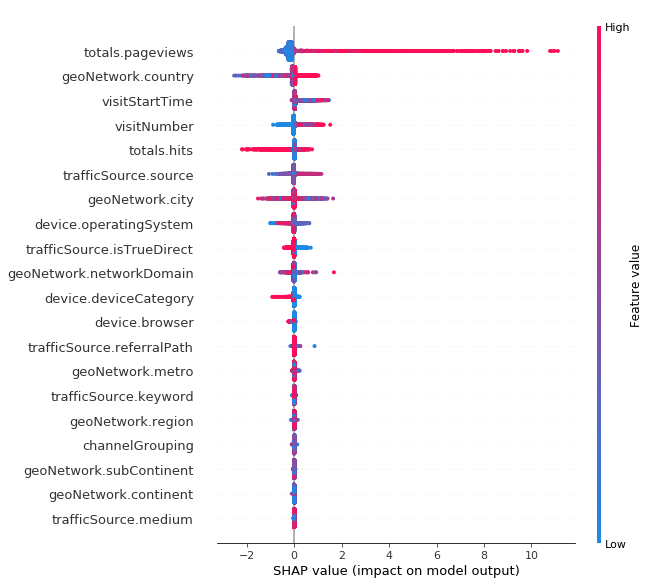

In [9]:
shap.summary_plot(shap_values, shap_X)

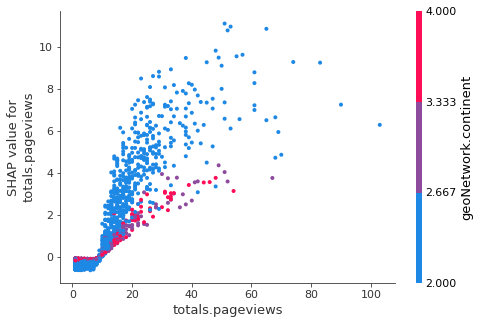

In [10]:
shap.dependence_plot("totals.pageviews", shap_values, shap_X)

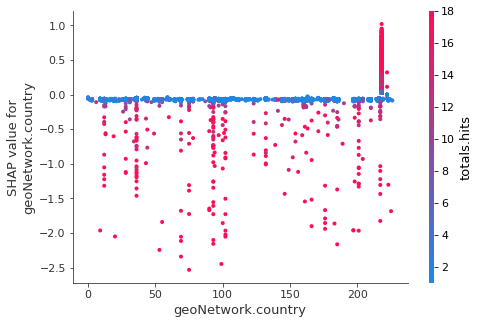

In [11]:
shap.dependence_plot("geoNetwork.country", shap_values, shap_X)